## This notebook contains a trial example of training a semantic segmentation model to recognize different components of an image trained on a publicly available and existing dataset. The goal is to determine whether such an approach is viable for our team's goals - identifying parts of a charger - as well as to explore and understand the process in a hands on manner. 

### Very basic example of training a transformer on a dataset, the cell below contains dependencies that you may potentially require to run the code.

In [47]:
"""
%pip install -q transformers datasets evaluate segments-ai
%pip install ipywidgets
%pip install -q datasets transformers evaluate wandb
%pip install torch
%pip install albumentations
%pip install transformers[torch]
%pip install tf-keras
"""

### Things you're gonna need:
1. A hugging face account and a login token
2. A mandb account and api key
3. time

### Additional todo/resource to look at in regards to building a custom dataset and training a model on that [VERY IMPORTANT]:
https://huggingface.co/blog/fine-tune-segformer#2-load-and-prepare-the-hugging-face-dataset-for-training
### This will contain resources regarding labeling/annotating and creating masks, as well as a basic overview on how to train a transformer model on the dataset

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import json
from PIL import Image
import matplotlib.patches as patches
from huggingface_hub import notebook_login, hf_hub_download
import albumentations as A
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, Trainer, TrainingArguments
import torch
from torch import nn
import multiprocessing
import evaluate




c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:


# You're gonna need a huggingface acct and token for this

notebook_login()

In [4]:
#you're gonna need access, after logging into hf, go this link and accept to gain access
# https://huggingface.co/datasets/segments/sidewalk-semantic
sidewalk_dataset_identifier = "segments/sidewalk-semantic"
from datasets import load_dataset

dataset = load_dataset(sidewalk_dataset_identifier)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

In [6]:
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [7]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 800
})

In [53]:
image = train_ds[0]
image

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>}

In [54]:

filename = "id2label.json"

id2label = json.load(

    open(hf_hub_download(repo_id=sidewalk_dataset_identifier, filename=filename, repo_type="dataset"), "r")

)

id2label = {int(k): v for k, v in id2label.items()}

label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

print("Id2label:", id2label)

Id2label: {0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


In [55]:
#ASSIGNING COLORS TO CLASSES
sidewalk_palette = [
    [0, 0, 0],  # unlabeled
    [216, 82, 24],  # flat-road
    [255, 255, 0],  # flat-sidewalk
    [125, 46, 141],  # flat-crosswalk
    [118, 171, 47],  # flat-cyclinglane
    [161, 19, 46],  # flat-parkingdriveway
    [255, 0, 0],  # flat-railtrack
    [0, 128, 128],  # flat-curb
    [190, 190, 0],  # human-person
    [0, 255, 0],  # human-rider
    [0, 0, 255],  # vehicle-car
    [170, 0, 255],  # vehicle-truck
    [84, 84, 0],  # vehicle-bus
    [84, 170, 0],  # vehicle-tramtrain
    [84, 255, 0],  # vehicle-motorcycle
    [170, 84, 0],  # vehicle-bicycle
    [170, 170, 0],  # vehicle-caravan
    [170, 255, 0],  # vehicle-cartrailer
    [255, 84, 0],  # construction-building
    [255, 170, 0],  # construction-door
    [255, 255, 0],  # construction-wall
    [33, 138, 200],  # construction-fenceguardrail
    [0, 170, 127],  # construction-bridge
    [0, 255, 127],  # construction-tunnel
    [84, 0, 127],  # construction-stairs
    [84, 84, 127],  # object-pole
    [84, 170, 127],  # object-trafficsign
    [84, 255, 127],  # object-trafficlight
    [170, 0, 127],  # nature-vegetation
    [170, 84, 127],  # nature-terrain
    [170, 170, 127],  # sky
    [170, 255, 127],  # void-ground
    [255, 0, 127],  # void-dynamic
    [255, 84, 127],  # void-static
    [255, 170, 127],  # void-unclear
]

### Taking a look at our data

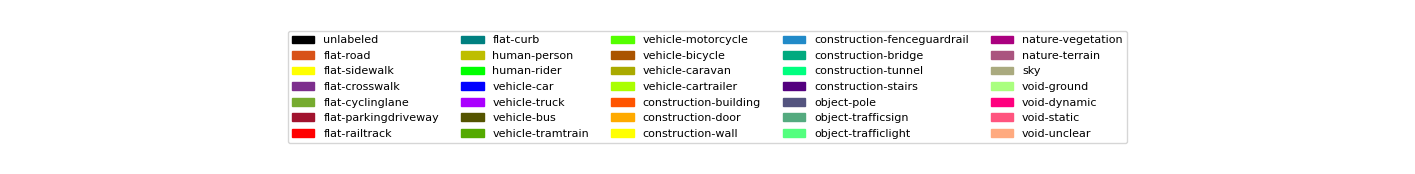

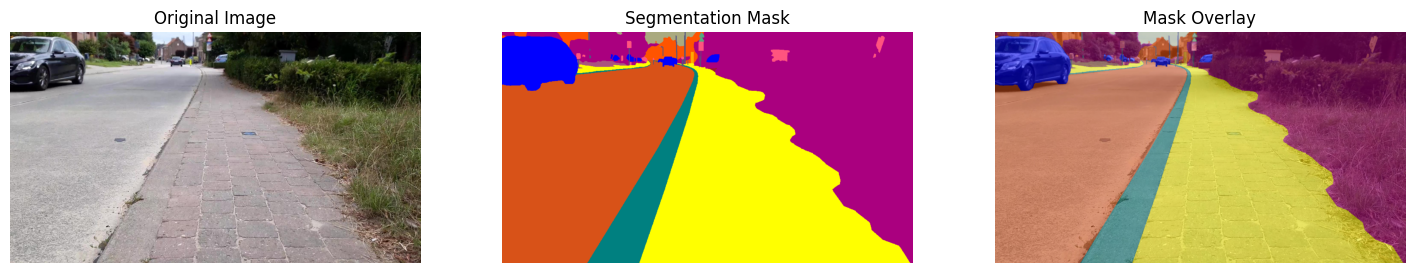

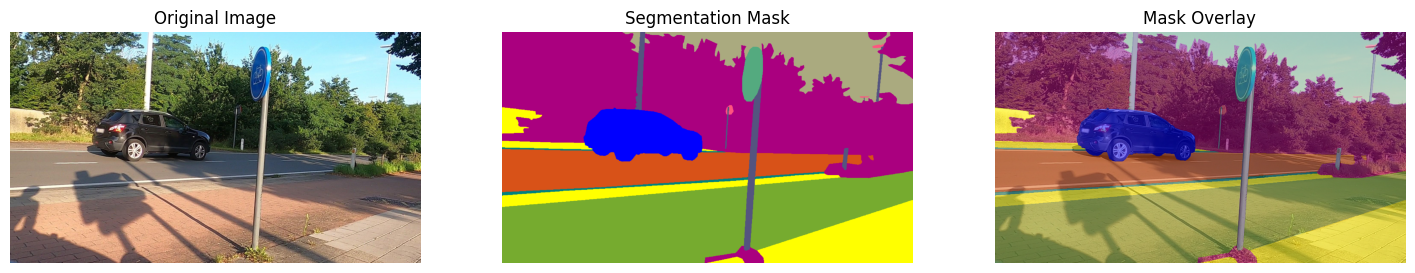

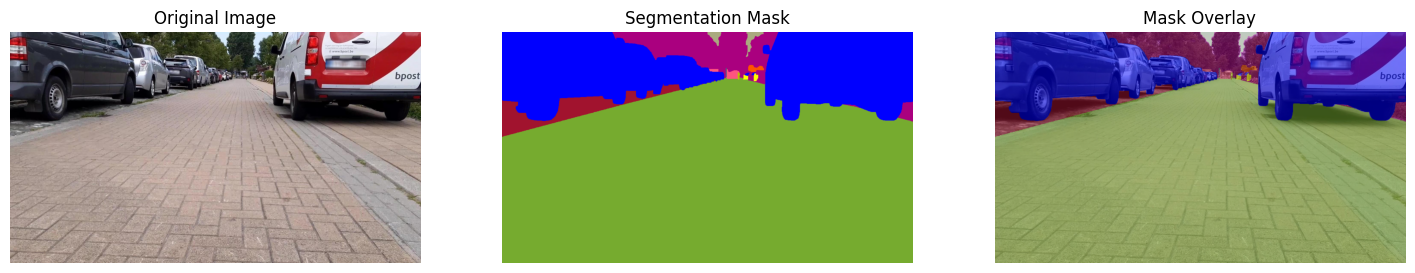

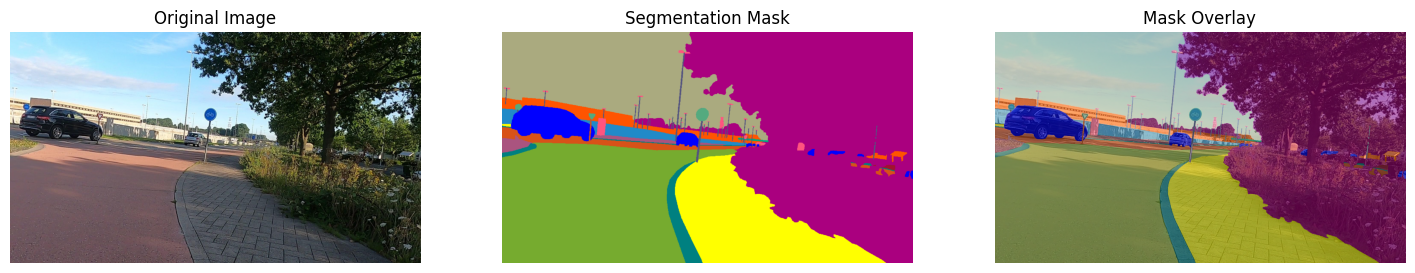

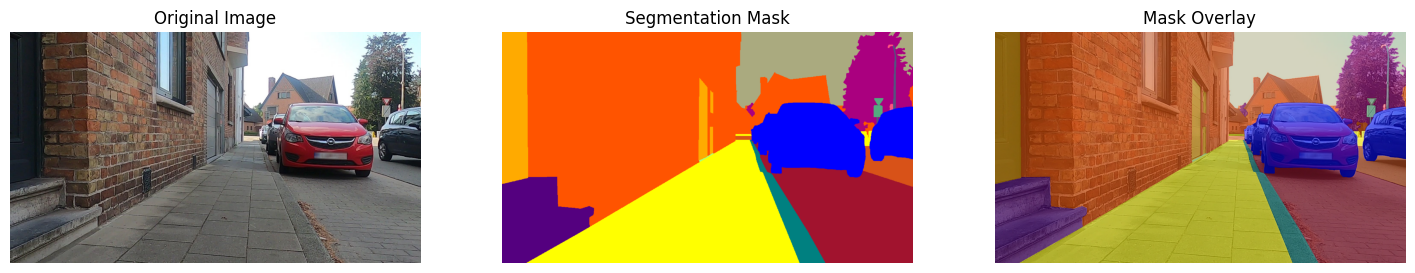

In [ ]:

# Create and show the legend separately

fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [

    patches.Patch(color=np.array(color) / 255, label=label)

    for label, color in zip(id2label.values(), sidewalk_palette)

]

ax.legend(handles=legend_patches, loc="center", bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)

ax.axis("off")

plt.show()

for i in range(5):

    image = train_ds[i]
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # original image plot
    #_______________________________________________
    ax[0].imshow(image["pixel_values"])
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    mask_np = np.array(image["label"])

    # mask ONLY plot
    #_______________________________________________

    # Create a new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Assign colors to each value in the mask
    for label_id, color in enumerate(sidewalk_palette):
        colored_mask[mask_np == label_id] = color
    colored_mask_img = Image.fromarray(colored_mask, "RGB")

    ax[1].imshow(colored_mask_img)
    ax[1].set_title("Segmentation Mask")
    ax[1].axis("off")


    # overlaid plot
    #_______________________________________________
    # Convert the original image to RGBA to support transparency

    image_rgba = image["pixel_values"].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # Adjust transparency of the mask

    alpha = 128  # Transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)

    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay

    ax[2].imshow(superposed)
    ax[2].set_title("Mask Overlay")
    ax[2].axis("off")
    plt.show()

In [58]:

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example["label"])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

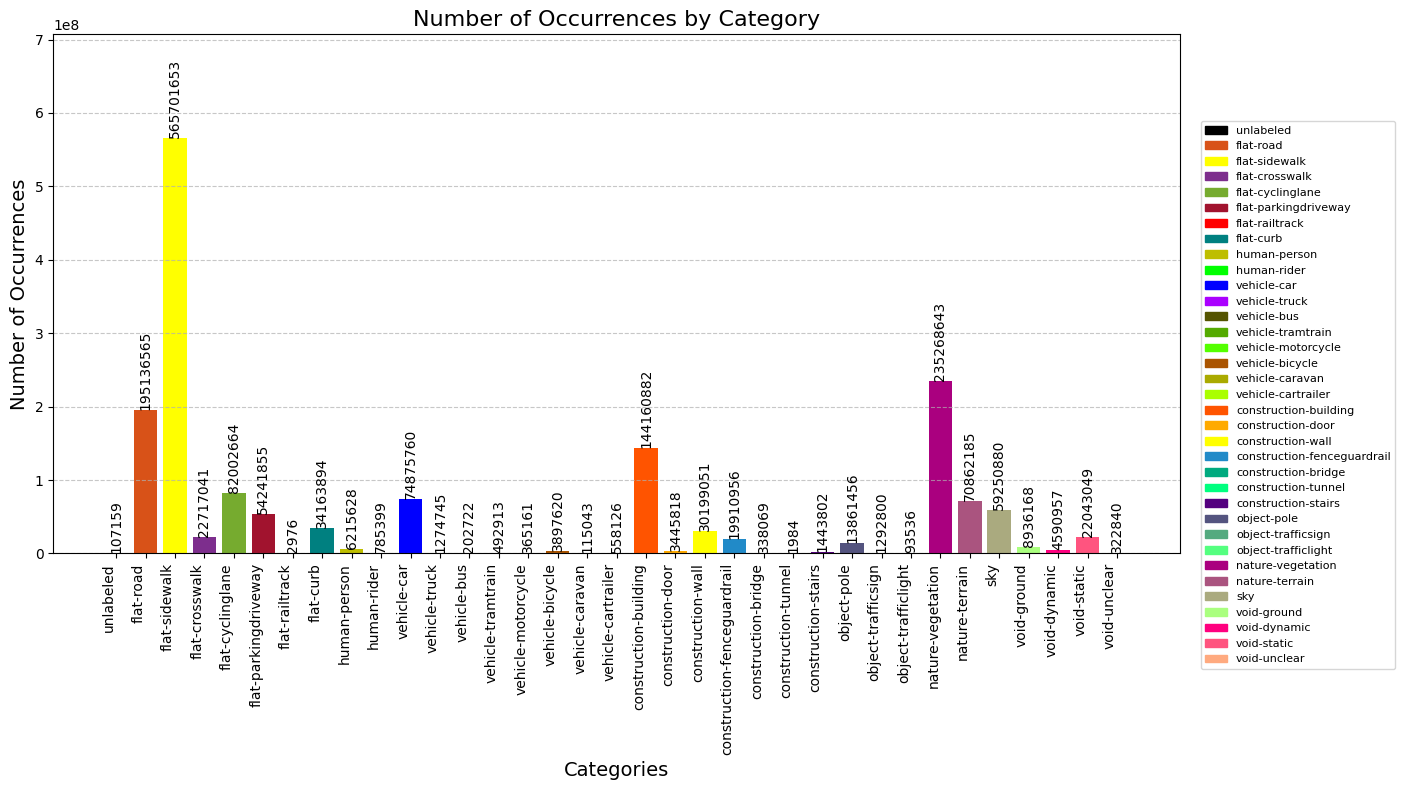

In [12]:

labels = list(id2label.values())

# Normalize colors to [0, 1]

normalized_palette = [tuple(c / 255 for c in color) for color in sidewalk_palette]

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")
ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust the y-axis limit

y_max = max(class_counts)

ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10  # Adjust the text location
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + offset,
        f"{height}",
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=10,
        color="black",
    )

fig.legend(
    handles=legend_patches, loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8
)  # Adjust ncol as needed

plt.tight_layout()
plt.show()

Here, we need an image processor. This is because not all images have the same filetype, shape (pixels), and we may want to introduce data augmentation.

In [24]:
image_processor = SegformerImageProcessor()

albumentations_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
        #A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(var_limit=(10, 50), p=0.4),
    ]
)


def train_transforms(example_batch):
    augmented = [
        albumentations_transform(image=np.array(image), mask=np.array(label))
        for image, label in zip(example_batch["pixel_values"], example_batch["label"])
    ]
    augmented_images = [item["image"] for item in augmented]
    augmented_labels = [item["mask"] for item in augmented]
    inputs = image_processor(augmented_images, augmented_labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

C:\Users\dskon\AppData\Local\Temp\ipykernel_23936\2236586923.py:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.4),


In [ ]:

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name, id2label=id2label, label2id=label2id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:

output_dir = "test-segformer-b0-segments-sidewalk-finetuned"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=6e-5,
    num_train_epochs=2, # gonna need to set this higher if we want a good model, this just for example so training doesnt blow up ur pc
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="wandb",
)

In [27]:
import wandb

#login thru cli by running "wandb login", then pasting api key

In [28]:
wandb.init(
    project="test-segformer-b0-segments-sidewalk-finetuned", 
    name="test-segformer-b0-segments-sidewalk-finetuned",  
    config=training_args,
)


In [29]:

evaluate.logging.set_verbosity_error()

In [30]:

metric = evaluate.load("mean_iou")


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        # currently using _compute instead of compute: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        pred_labels = logits_tensor.detach().cpu().numpy()
        import warnings

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

In [37]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
trainer.train()

C:\Users\dskon\AppData\Local\Temp\ipykernel_23936\206319361.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Unlabeled,Accuracy Flat-road,Accuracy Flat-sidewalk,Accuracy Flat-crosswalk,Accuracy Flat-cyclinglane,Accuracy Flat-parkingdriveway,Accuracy Flat-railtrack,Accuracy Flat-curb,Accuracy Human-person,Accuracy Human-rider,Accuracy Vehicle-car,Accuracy Vehicle-truck,Accuracy Vehicle-bus,Accuracy Vehicle-tramtrain,Accuracy Vehicle-motorcycle,Accuracy Vehicle-bicycle,Accuracy Vehicle-caravan,Accuracy Vehicle-cartrailer,Accuracy Construction-building,Accuracy Construction-door,Accuracy Construction-wall,Accuracy Construction-fenceguardrail,Accuracy Construction-bridge,Accuracy Construction-tunnel,Accuracy Construction-stairs,Accuracy Object-pole,Accuracy Object-trafficsign,Accuracy Object-trafficlight,Accuracy Nature-vegetation,Accuracy Nature-terrain,Accuracy Sky,Accuracy Void-ground,Accuracy Void-dynamic,Accuracy Void-static,Accuracy Void-unclear,Iou Unlabeled,Iou Flat-road,Iou Flat-sidewalk,Iou Flat-crosswalk,Iou Flat-cyclinglane,Iou Flat-parkingdriveway,Iou Flat-railtrack,Iou Flat-curb,Iou Human-person,Iou Human-rider,Iou Vehicle-car,Iou Vehicle-truck,Iou Vehicle-bus,Iou Vehicle-tramtrain,Iou Vehicle-motorcycle,Iou Vehicle-bicycle,Iou Vehicle-caravan,Iou Vehicle-cartrailer,Iou Construction-building,Iou Construction-door,Iou Construction-wall,Iou Construction-fenceguardrail,Iou Construction-bridge,Iou Construction-tunnel,Iou Construction-stairs,Iou Object-pole,Iou Object-trafficsign,Iou Object-trafficlight,Iou Nature-vegetation,Iou Nature-terrain,Iou Sky,Iou Void-ground,Iou Void-dynamic,Iou Void-static,Iou Void-unclear
20,2.141500,1.919021,0.128786,0.178410,0.699240,nan,0.629569,0.916192,0.000000,0.444251,0.000628,nan,0.000000,0.000000,0.000000,0.767560,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.835345,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.945288,0.088401,0.903465,0.000000,0.000000,0.000000,0.000000,0.000000,0.457716,0.711226,0.000000,0.401871,0.000625,nan,0.000000,0.000000,0.000000,0.525554,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.502248,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.676362,0.081686,0.763859,0.000000,0.000000,0.000000,0.000000
40,1.823600,1.636567,0.142404,0.192686,0.715783,nan,0.732717,0.899544,0.000000,0.374322,0.000242,nan,0.000000,0.000000,0.000000,0.837657,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.838604,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.931706,0.463045,0.895419,0.000000,0.000000,0.000000,0.000000,0.000000,0.452478,0.725092,0.000000,0.358036,0.000242,nan,0.000000,0.000000,0.000000,0.542673,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.532102,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.728445,0.404020,0.813839,0.000000,0.000000,0.000000,0.000000
60,1.574500,1.550978,0.150722,0.202186,0.731880,nan,0.717301,0.905732,0.000000,0.543852,0.000210,nan,0.000000,0.000000,0.000000,0.847720,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.863503,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.927628,0.558823,0.903009,0.000000,0.000000,0.000000,0.000000,0.000000,0.493850,0.734180,0.000000,0.477234,0.000210,nan,0.000000,0.000000,0.000000,0.573136,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.542475,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.734797,0.447928,0.819303,0.000000,0.000000,0.000000,0.000000
80,1.816500,1.502324,0.148525,0.200437,0.730676,nan,0.745527,0.898772,0.000000,0.534777,0.000078,nan,0.000000,0.000000,0.000000,0.873099,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.859877,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.935559,0.443934,0.921921,0.000000,0.000000,0.000000,0.000000,0.000000,0.493833,0.741742,0.000000,0.490724,0.000077,nan,0.000000,0.000000,0.000000,0.565288,0.000000,0

TrainOutput(global_step=200, training_loss=1.6675523495674134, metrics={'train_runtime': 1538.379, 'train_samples_per_second': 1.04, 'train_steps_per_second': 0.13, 'total_flos': 2.81087582404608e+16, 'train_loss': 1.6675523495674134, 'epoch': 2.0})

In [38]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

image = Image.open(requests.get(url, stream=True).raw)

image_segmentator = pipeline(
    "image-segmentation",
    model="sergiopaniego/test-segformer-b0-segments-sidewalk-finetuned",  # Change with your model name
)

results = image_segmentator(image)

config.json:   0%|          | 0.00/2.94k [00:00<?, ?B/s]

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dskon\.cache\huggingface\hub\models--sergiopaniego--test-segformer-b0-segments-sidewalk-finetuned. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


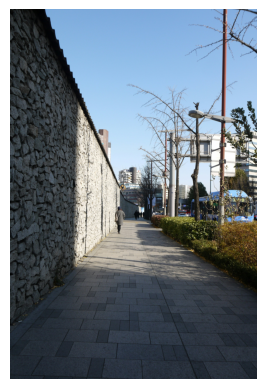

In [39]:
plt.imshow(image)

plt.axis("off")

plt.show()

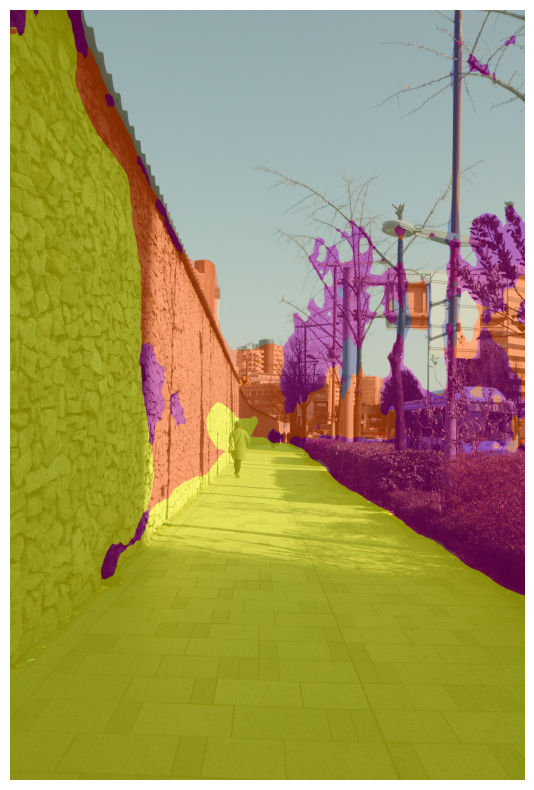

In [40]:
image_array = np.array(image)

segmentation_map = np.zeros_like(image_array)

for result in results:

    mask = np.array(result["mask"])

    label = result["label"]

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):

        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))

plt.imshow(image_array)

plt.imshow(segmentation_map, alpha=0.5)

plt.axis("off")

plt.show()